In [19]:
# Sentiment Analysis - War and Peace & Anna Karenina

import os
import re
import json
import math
from tqdm import tqdm
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline


In [20]:
# Define data directory and load text files

# Folders
DATA_DIR = Path("../../data") if Path(".").name != "applied-NLP-project" else Path("data")
RESULTS_DIR = Path("../../results") if Path(".").name != "applied-NLP-project" else Path("results")
OUT_DIR = RESULTS_DIR / "sentiment_analysis"
OUT_DIR.mkdir(parents=True, exist_ok=True)

BOOKS = {
    "War_and_Peace": DATA_DIR / "War_and_Peace.txt",
    "Anna_Karenina": DATA_DIR / "Anna_Karenina.txt",
}

# Sanity: make sure texts exist and are not tiny HTML error pages
for name, p in BOOKS.items():
    if not p.exists() or p.stat().st_size < 100000:
        raise FileNotFoundError(f"{name} missing/invalid: {p}")

# ✅ Load texts into memory
TEXTS = {}
for name, path in BOOKS.items():
    with open(path, "r", encoding="utf-8") as f:
        TEXTS[name] = f.read()

print(f"Loaded {len(TEXTS)} books:")
for name, text in TEXTS.items():
    print(f" - {name}: {len(text):,} characters")


Loaded 2 books:
 - War_and_Peace: 3,227,520 characters
 - Anna_Karenina: 1,964,866 characters


In [21]:
# Initialize Hugging Face sentiment analysis model

sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
print("✅ Sentiment model loaded successfully.")


✅ Sentiment model loaded successfully.


In [22]:
# Helper functions for cleaning and analyzing sentiment

def clean_text(text):
    """Clean text by removing extra whitespace."""
    return re.sub(r'\s+', ' ', text).strip()

def analyze_sentiment(text, chunk_size=512):
    """Perform sentiment analysis across sentences and return percentage ratios."""
    text = clean_text(text)
    sentences = re.split(r'(?<=[.!?]) +', text)
    results = {"positive": 0, "neutral": 0, "negative": 0}

    label_map = {
        "LABEL_0": "negative",
        "LABEL_1": "neutral",
        "LABEL_2": "positive",
        "negative": "negative",
        "neutral": "neutral",
        "positive": "positive"
    }

    for sent in tqdm(sentences, desc="Analyzing sentiment"):
        if len(sent.strip()) < 5:
            continue
        raw_label = sentiment_model(sent[:chunk_size])[0]["label"]
        sentiment = label_map.get(raw_label.upper(), "neutral")  # fallback to neutral
        results[sentiment] += 1

    total = sum(results.values())
    for k in results:
        results[k] = round((results[k] / total) * 100, 2)
    return results



In [23]:
# Run sentiment analysis for both novels

results = {}
for name, text in TEXTS.items():
    print(f"\n🔍 Processing {name}...")
    results[name] = analyze_sentiment(text)

# Display results
for name, res in results.items():
    print(f"\n📘 {name} Sentiment Ratio (%): {res}")



🔍 Processing War_and_Peace...


Analyzing sentiment: 100%|██████████| 27265/27265 [19:36<00:00, 23.18it/s]



🔍 Processing Anna_Karenina...


Analyzing sentiment: 100%|██████████| 17074/17074 [12:31<00:00, 22.72it/s]


📘 War_and_Peace Sentiment Ratio (%): {'positive': 12.63, 'neutral': 69.0, 'negative': 18.37}

📘 Anna_Karenina Sentiment Ratio (%): {'positive': 14.69, 'neutral': 64.79, 'negative': 20.52}


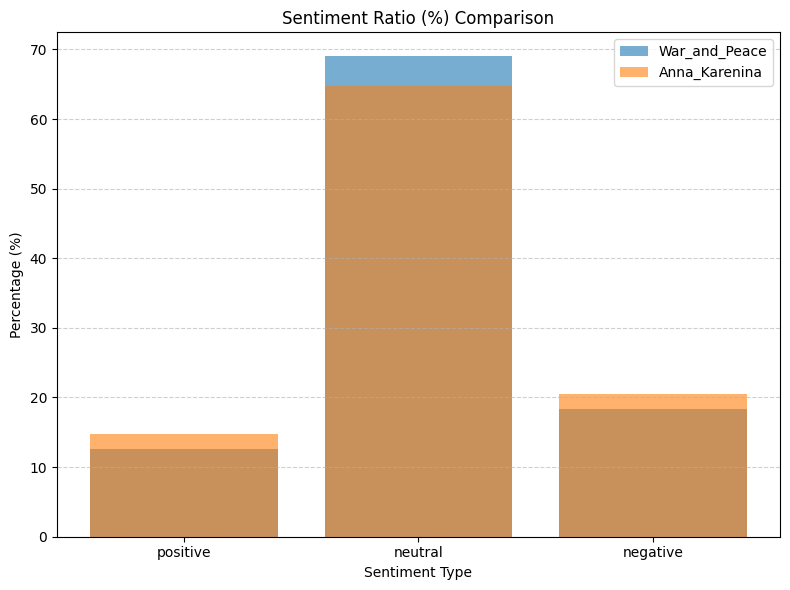

In [24]:
# Visualization
plt.figure(figsize=(8,6))
labels = ["positive", "neutral", "negative"]

for book, data in results.items():
    plt.bar(labels, data.values(), alpha=0.6, label=book)

plt.title("Sentiment Ratio (%) Comparison")
plt.xlabel("Sentiment Type")
plt.ylabel("Percentage (%)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [25]:
# Save results
out_file = OUT_DIR / "sentiment_results.json"
with open(out_file, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=4)

print(f"✅ Sentiment results saved to {out_file}")


✅ Sentiment results saved to ..\..\results\sentiment_analysis\sentiment_results.json
